# [3] American SIgn Language Translator Model - CNN

### Installing required libraries

In [1]:
!pip install graphviz
!pip install mediapipe
!pip install opencv-python
!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install seaborn

### Importing necessary libraries

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D
from keras_visualizer import visualizer

from keras.utils import plot_model
#from keras.callbacks import Callback
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm 

### Verifying GPU is being used and configured

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15589518651998135226,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3044750132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6166110882352823361
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

### Creating labels for the categories

In [5]:
y_labels = ['A', 'B', 'C', 'D', 'E', 
            'F', 'G', 'H', 'I', 'J', 
            'K', 'L', 'M', 'N', 'O', 
            'P', 'Q', 'R', 'S', 'T', 
            'U', 'V', 'W', 'X', 'Y', 
            'Z']

### Trainning hyper parameters

In [6]:
batch_size = 128
epochs = 25
num_classes = 26

### Loading the landmark datasets

In [7]:
x_data = np.load('x_data.npy')
y_data = np.load('y_data.npy')
x_dimm, y_dimm = x_data.shape[1:]

### Printing shape of the loaded data to verify everything is fine

In [8]:
print(x_data.shape)
print(y_data.shape)
print(x_dimm, y_dimm)

(231276, 7, 9)
(231276,)
7 9


### Shuffling and splitting the data into trainning and testing data

In [9]:

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    train_size = 0.90)

### Adding an extra dimension to the input data since Conv2D layer accepts a 4D tensor as input

In [10]:
x_train = x_train.reshape(x_train.shape[0], x_dimm, y_dimm, 1)
x_test = x_test.reshape(x_test.shape[0],    x_dimm, y_dimm, 1)

In [11]:
print("x_train = ", x_train.shape)
print("y_train = ",y_train.shape)

print("x_test  = ",x_test.shape)
print("y_train = ",y_train.shape)

x_train =  (208148, 7, 9, 1)
y_train =  (208148,)
x_test  =  (23128, 7, 9, 1)
y_train =  (208148,)


## One-hot encoding the y labels
Converting the labels into categorical data 

In [12]:
encoder = LabelBinarizer()
y_train_cat = encoder.fit_transform(y_train)
y_test_cat  = encoder.fit_transform(y_test)

print("y_train_cat = ",y_train_cat.shape)
print("y_test_cat  = ",y_test_cat.shape)

y_train_cat =  (208148, 26)
y_test_cat  =  (23128, 26)


## Creating the baseline model.

In [13]:
def baseline_model():
    model = Sequential()
    
    #convoltional layer
    model.add(Conv2D(32, 
                    kernel_size = (3,3),
                    activation = 'relu',
                    input_shape = x_train.shape[1:]))
    model.add(Flatten())
    
    #dense layer 1
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.4))
    
    #dense layer 2
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.4))
    
    #dense layer 3
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.4))
    
    #output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compiling the model
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])
    
    # displaying the summary of the model
    print(model.summary())
    return model

In [14]:
baseline = baseline_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 7, 32)          320       
_________________________________________________________________
flatten (Flatten)            (None, 1120)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               448400    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1

### Trainning the baseline model

In [15]:
baseline_log = baseline.fit(x_train, # x data for trainning
             y_train_cat,            # y data for trainning 
             batch_size = batch_size,# batch size for trainning
             epochs = epochs,        # number of epochs
             validation_split = 0.2, # 20% of input data goes for validation
             verbose=1)              # show detailed stats of trainning

Epoch 1/25
1301/1301 [==============================] - 18s 8ms/step - loss: 2.0163 - accuracy: 0.3726 - val_loss: 0.4738 - val_accuracy: 0.8584
Epoch 2/25
1301/1301 [==============================] - 8s 6ms/step - loss: 0.6661 - accuracy: 0.7981 - val_loss: 0.3314 - val_accuracy: 0.9062
Epoch 3/25
1301/1301 [==============================] - 9s 7ms/step - loss: 0.5079 - accuracy: 0.8555 - val_loss: 0.2721 - val_accuracy: 0.9213
Epoch 4/25
1301/1301 [==============================] - 8s 6ms/step - loss: 0.4370 - accuracy: 0.8778 - val_loss: 0.2435 - val_accuracy: 0.9301
Epoch 5/25
1301/1301 [==============================] - 8s 6ms/step - loss: 0.3896 - accuracy: 0.8920 - val_loss: 0.2324 - val_accuracy: 0.9311
Epoch 6/25
1301/1301 [==============================] - 8s 6ms/step - loss: 0.3633 - accuracy: 0.9000 - val_loss: 0.2298 - val_accuracy: 0.9324
Epoch 7/25
1301/1301 [==============================] - 8s 6ms/step - loss: 0.3427 - accuracy: 0.9068 - val_loss: 0.2118 - val_accuracy

### Function to plot the accuracy and loss of a model

In [16]:
def plot_accuracy(model, history):
    # running the model on the testing dataset
    eval_loss, eval_accuracy = model.evaluate(x_test, 
                                              y_test_cat, 
                                              verbose = 0)
    
    # displaying trainning accuracy and loss
    print("Train loss          = ", history.history['loss'][-1]*100)
    print("Train accuracy      = ", history.history['accuracy'][-1]*100)
    print()
    
    # displaying validation accuracy and loss
    print("Validation loss     = ", history.history['val_loss'][-1]*100)
    print("Validation accuracy = ", history.history['val_accuracy'][-1]*100)
    print()
    
    # displaying the trainning accuracy and loss
    print("test loss           = ",eval_loss*100)
    print("test accuracy       = ",eval_accuracy*100)
    
    # creating sub plots for accuracy and loss
    plt.subplot(2,1,1)
    
    # plotting model accuracy
    plt.title('Model Accuracy')
    plt.plot(range(epochs), history.history['accuracy'])
    plt.plot(range(epochs), history.history['val_accuracy'])
    
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # plotting model loss
    plt.subplot(2,1,2)
    plt.title('Model loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()

### Plotting the accuracy of the baseline model

Train loss          =  22.362948954105377
Train accuracy      =  93.80847811698914

Validation loss     =  15.423917770385742
Validation accuracy =  95.67619562149048

test loss           =  15.354593098163605
test accuracy       =  95.4730212688446


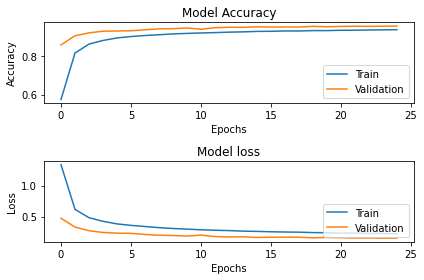

In [17]:
plot_accuracy(baseline, baseline_log)

### Creating confusion matrix
Generating a confusion matrix to make sure that the model
is not getting confused among similar signs, like a and s

In [19]:
y_prediction = np.argmax( baseline.predict(x_test), axis = 1)
y_testing   = np.argmax( y_test_cat, axis = 1)

conf_mat = confusion_matrix( y_testing, y_prediction, normalize = 'true')

### Plotting the confuision matrix

<AxesSubplot:>

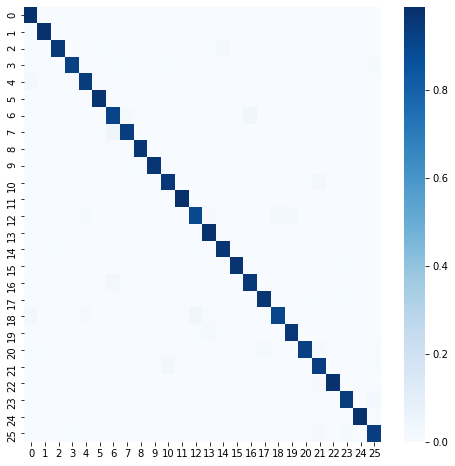

In [20]:
plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat,
           cmap = "Blues")

### Saving the model

In [21]:
baseline.save("baseline.model", save_format="h5")